In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from subspace_clustering_helper_funcs import *
from ae_eval_and_vis import *

In [2]:
import warnings
warnings.filterwarnings('ignore')
# C:\Users\kdmen\miniconda3\envs\fl_torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning warnings.warn(

# Load in Data

In [15]:
# remove pID 101 because it doesn't exist
# remove pID 131 because it  doesnt have enough user defined gestures
# each participant has 100 experimenter defined files and 50 user defined files
# 10 experimenter defined gestures and 5 user defined gestures

file_types = ["IMU_extract", "movavg_files"]
expt_types = ["experimenter-defined"]

#remove participant 131 because they are missing gestures 
pIDs_impaired = ['P102','P103','P104','P105','P106','P107','P108','P109','P110','P111',
       'P112','P114','P115','P116','P118','P119','P121','P122','P123','P124','P125',
       'P126','P127','P128', 'P132']
# remove participants P001 and P003 because they dont have duplicate or open gestures
pIDs_unimpaired = ['P004','P005','P006','P008','P010','P011']

pIDs_both = pIDs_impaired + pIDs_unimpaired

# Kai's laptop
base_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\"
# BRC Desktop
#data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\"

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']
metadata_cols_df = pd.read_pickle(base_path+'metadata_cols_df.pkl')

num_rows_per_gesture = 64

# Maximum number of components
max_clusters = 12
num_clusters_range = list(range(2, max_clusters+1))

In [4]:
# Kai's laptop
data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\PCA_40D\\"
# BRC Desktop
#data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\"

print("Loading")

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']

PCA_df = pd.read_pickle(data_path+'PCA_ms_IMUEMG_df.pkl')
metadata_cols_df = pd.read_pickle('C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\metadata_cols_df.pkl')

# Dropping the metadata when we read it in!
training_u_df = pd.read_pickle(data_path+'training_u_df.pkl').drop(metadata_cols, axis=1)
test_users_df = pd.read_pickle(data_path+'test_users_df.pkl').drop(metadata_cols, axis=1)

Loading


In [5]:
print(training_u_df.shape)
training_u_df.head()

(327168, 40)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.027903,0.001411,-0.019509,0.013428,-0.019699,0.027333,-0.031254,-0.022910,0.066484,0.108729,...,-0.019453,0.062983,-0.025869,0.014303,-0.013387,-0.037645,-0.186270,-0.046251,-0.104630,-0.002939
1,-0.038982,0.006470,-0.000111,0.010904,-0.015323,0.031336,-0.007901,-0.027368,0.060370,0.074712,...,0.041438,0.035053,-0.056843,-0.008895,-0.022542,-0.022563,-0.160826,-0.048161,-0.073771,0.043268
2,-0.116782,0.003824,0.011550,-0.014612,-0.093325,0.081718,-0.013155,-0.046150,0.036385,0.052746,...,-0.014298,0.072109,-0.026536,-0.034365,0.018695,-0.011940,-0.160580,-0.041831,-0.109653,0.027043
3,-0.030245,-0.017409,0.022540,-0.048905,-0.029129,0.090026,-0.024645,-0.064307,0.074589,0.053055,...,-0.010992,0.059990,-0.097073,-0.056870,-0.001038,-0.008015,-0.165858,-0.049424,-0.108671,0.069886
4,-0.112950,0.026262,0.004837,-0.063254,-0.108892,0.198729,-0.010583,-0.124893,0.114817,0.038628,...,0.035735,0.050880,-0.093678,-0.131263,0.018035,0.056185,-0.157963,-0.041911,-0.145308,0.063311


In [6]:
# CREATE THE TRAINING SET
num_rows_per_gesture = 64 # From the interp
num_gestures = len(training_u_df) // num_rows_per_gesture
num_features = training_u_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(training_u_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
X_3D_PCA40 = training_u_df.to_numpy().reshape(num_gestures, num_rows_per_gesture, num_features)
#flattened_PCA = PCA_np.reshape(num_gestures, -1)

# Convert to PyTorch tensor
X_3DTensor_PCA40 = torch.tensor(X_3D_PCA40, dtype=torch.float32)

# Create the dataset
u_training_dataset = GestureDataset(X_3DTensor_PCA40)

batch_size = 32  # Adjust batch size as needed
train_loader = DataLoader(u_training_dataset, batch_size=batch_size, shuffle=True) # Should shuffle be False? 
## It's shuffling the gesture order I think so that should be fine...

# CREATE THE TEST SET
num_test_gestures = len(test_users_df) // num_rows_per_gesture
# Ensure the data can be evenly divided into gestures
assert len(test_users_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns) and convert to torch tensor
## Theres probably an easier way to just create it as a torch tensor lol
Xtest_3DTensor_PCA40 = torch.tensor(test_users_df.to_numpy().reshape(num_test_gestures, num_rows_per_gesture, num_features), dtype=torch.float32)

# Create the dataset
u_testing_dataset = GestureDataset(Xtest_3DTensor_PCA40)
test_loader = DataLoader(u_testing_dataset, batch_size=batch_size, shuffle=False)

## Load in and set up all saved models

In [7]:
# Kai:
model_dir_path = 'C:\\Users\\kdmen\\Desktop\\Research\\Repos\\fl-gestures\\models\\'
# BRC:
#model_dir_path = ''
timesteps = 64
num_features = 40
input_dim = 40

In [8]:
class RNNAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, seq_len, progressive=False):
        super(RNNAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.progressive = progressive
        
        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        current_hidden_dim = hidden_dim
        for i in range(num_layers):
            encoder_layers.append(nn.RNN(prev_dim, current_hidden_dim, batch_first=True))
            prev_dim = current_hidden_dim
            if progressive and current_hidden_dim > 1:
                current_hidden_dim = max(1, current_hidden_dim // 2)  # Ensure hidden_dim does not go below 1
        self.encoder = nn.ModuleList(encoder_layers)
        
        # Decoder
        decoder_layers = []
        if progressive:
            current_hidden_dim = max(1, current_hidden_dim) * 2 
            # Multiply by 2 bc the current_hidden_dim is halved at the end of the encoder
        for i in range(num_layers):
            next_hidden_dim = min(hidden_dim, current_hidden_dim * 2) if progressive else hidden_dim
            decoder_layers.append(nn.RNN(current_hidden_dim, next_hidden_dim, batch_first=True))
            current_hidden_dim = next_hidden_dim
        decoder_layers.append(nn.Linear(current_hidden_dim, input_dim))  # Final layer to match input_dim
        self.decoder = nn.ModuleList(decoder_layers)
        
    def forward(self, x):
        batch_size = x.size(0)
        # Encoding
        for rnn in self.encoder:
            x, _ = rnn(x)
        # Decoding
        for rnn in self.decoder[:-1]:
            x, _ = rnn(x)
        x = self.decoder[-1](x)  # Final linear layer to match input dimension
        return x

    def encode(self, x):
        for rnn in self.encoder:
            x, _ = rnn(x)
        return x

In [9]:
hidden_dim = 128
num_layers = 2
seq_len = 64
progressive = False
RNNAE_gridsearch_latent128_BothPCA40_model = RNNAutoencoder(input_dim, hidden_dim, num_layers, seq_len, progressive)

RNNAE_gridsearch_latent128_BothPCA40_model.load_state_dict(torch.load(model_dir_path+'RNNAE_latent128_progFalse_numlayers2_trial13_vallossp001_BothPCA40.pth'))

<All keys matched successfully>

> Need to know judge whether or not the AE is any good. The loss by itself doesn't tell if the AE is "good enough"

Average testing loss across the entire test_loader: 0.0017131721086079037


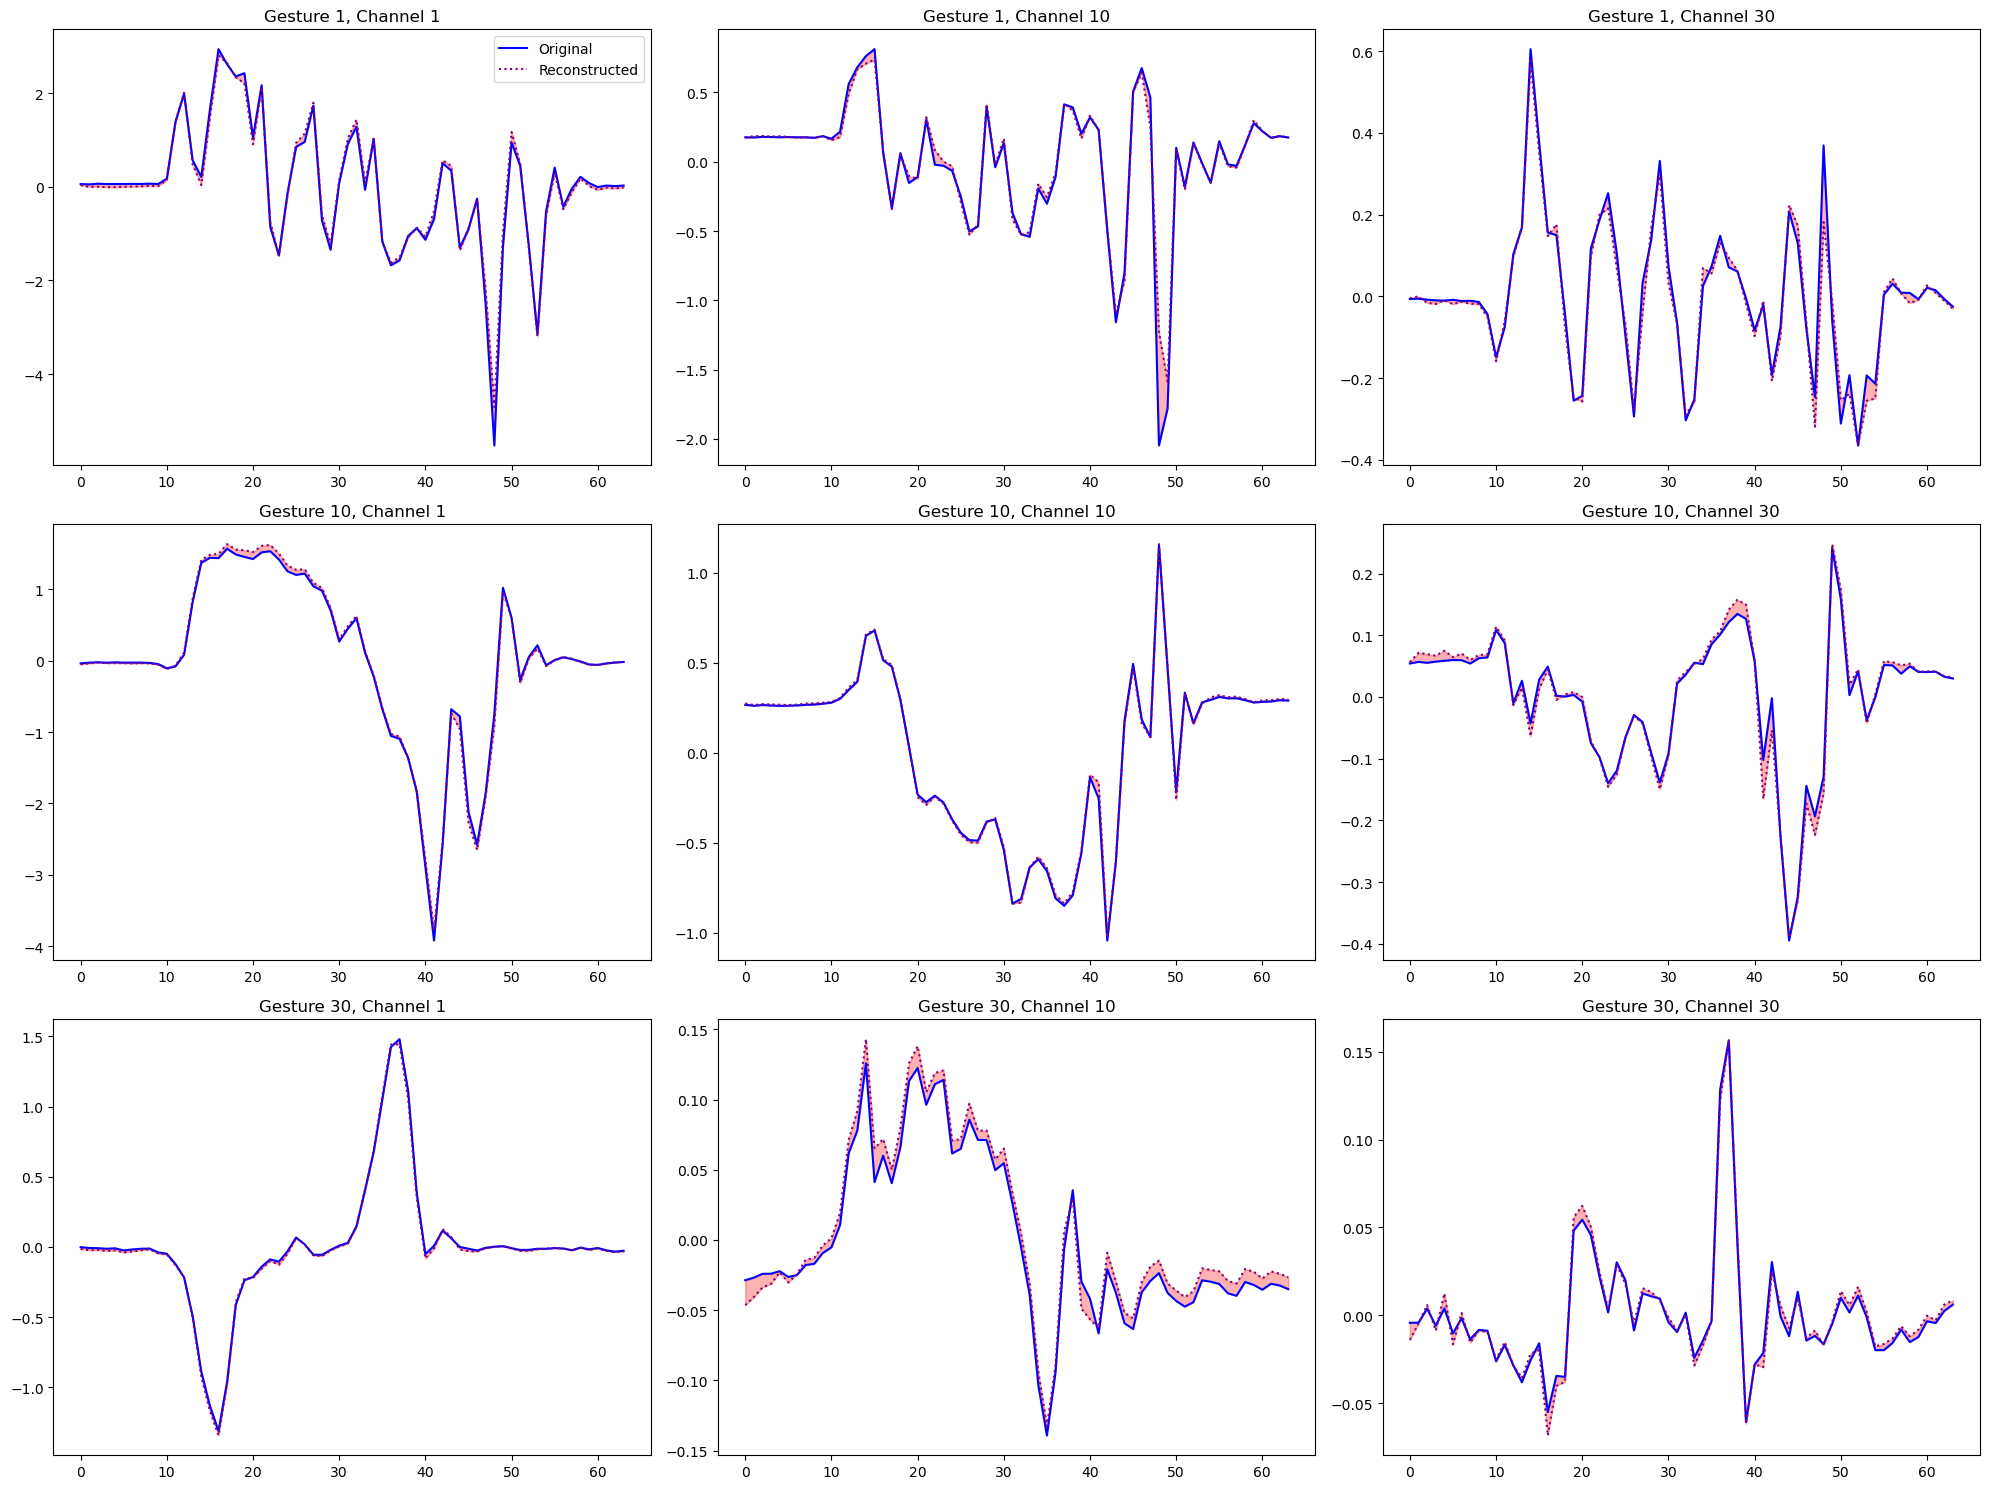

In [10]:
my_model = RNNAE_gridsearch_latent128_BothPCA40_model

average_test_loss, sample_data_lst, reconstructions_lst, latent_representations_lst = eval_on_testset_and_return_original_and_reconstructed(my_model, test_loader)
visualize_original_vs_reconstructed_gestures(sample_data_lst[0], reconstructions_lst[0])
#latent_space_vis(latent_representations_lst)

In [11]:
len(latent_representations_lst)

49

In [12]:
latent_representations = np.concatenate(latent_representations_lst)
print(latent_representations.shape)

(1556, 64, 128)


In [13]:
# Reshape to 2D since TSNE and such can't handle 3D inputs...
latent_representations_reshaped = latent_representations.reshape(latent_representations.shape[0], -1)
print(latent_representations_reshaped.shape)

(1556, 8192)


Whoa this one cooked, explained variance was only 12%...

In [14]:
# Hyperparameters
input_dim = 40
hidden_dim = 64
kernel_size = 5

# Model, Loss, and Optimizer
temp_conv_ae_model = TCNAutoencoder(input_dim, hidden_dim, kernel_size)


NameError: name 'TCNAutoencoder' is not defined

# Latent Space Clustering

In [16]:
km_silhouette_lst=[]
km_davies_bouldin_lst=[]
km_cali_har_lst=[]
km_dunn_index_lst=[]
km_gap_stat_lst=[]
for n in num_clusters_range:
    print(f"{n}/{num_clusters_range[-1]}")
    silhouette, db_index, ch_index, di_index, gap_stat = run_clustering_algorithm('KMeans', latent_representations_reshaped, num_clusters=n)
    km_silhouette_lst.append(silhouette)
    km_davies_bouldin_lst.append(db_index)
    km_cali_har_lst.append(ch_index)
    km_dunn_index_lst.append(di_index)
    km_gap_stat_lst.append(gap_stat)

2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
12/12


Plot the silhouette scores
> Higher is better

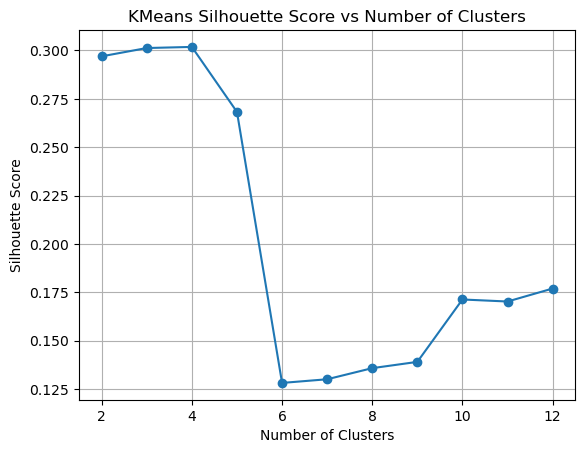

In [17]:
plt.plot(num_clusters_range, km_silhouette_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('KMeans Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

Plot the Davies-Bouldin score
> Lower is better

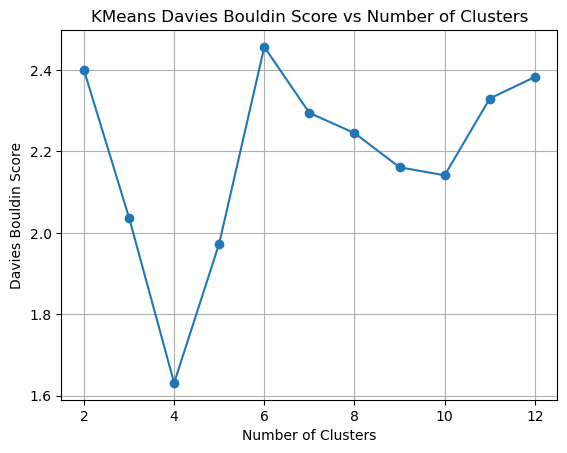

In [18]:
plt.plot(num_clusters_range, km_davies_bouldin_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies Bouldin Score')
plt.title('KMeans Davies Bouldin Score vs Number of Clusters')
plt.grid(True)
plt.show()

Plot the Calinski and Harabasz score
> Higher is better

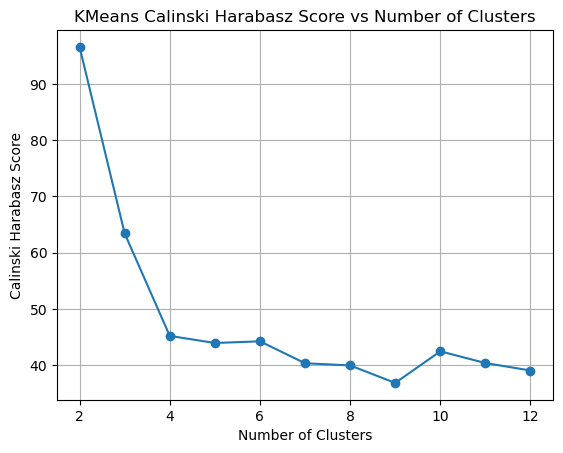

In [19]:
plt.plot(num_clusters_range, km_cali_har_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.title('KMeans Calinski Harabasz Score vs Number of Clusters')
plt.grid(True)
plt.show()

Plot the Dunn Index
> Higher is better

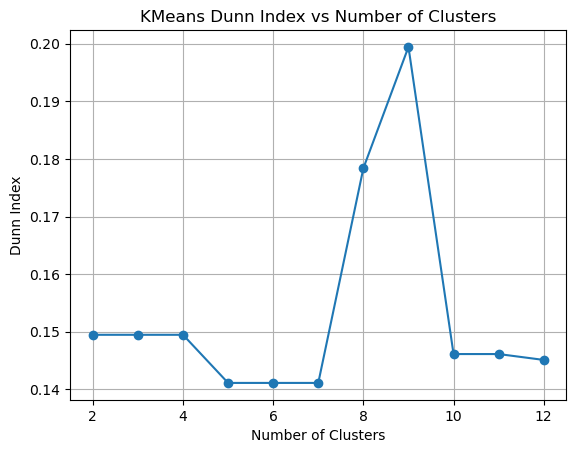

In [20]:
plt.plot(num_clusters_range, km_dunn_index_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Dunn Index')
plt.title('KMeans Dunn Index vs Number of Clusters')
plt.grid(True)
plt.show()

Plot the Gap Statistic
> Higher is better

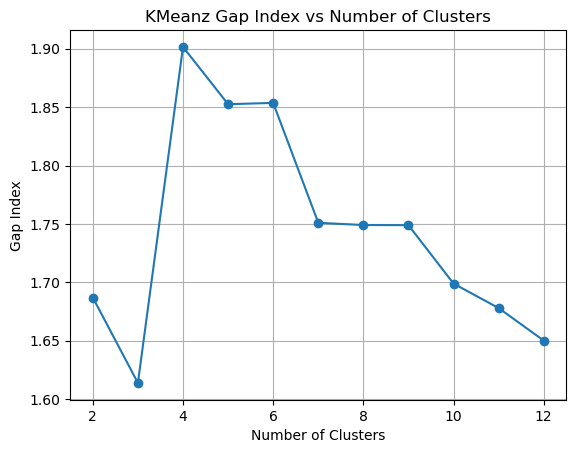

In [21]:
plt.plot(num_clusters_range, km_gap_stat_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Gap Index')
plt.title('KMeanz Gap Index vs Number of Clusters')
plt.grid(True)
plt.show()